In [3]:
import torch
import tqdm
import torch.nn as nn
from torchvision.models import resnet18

E:\Anaconda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
import pandas as pd
import os
from scipy.io import wavfile
from scipy.signal import stft
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
import librosa as lr
from spafe.features.gfcc import gfcc
from sklearn.preprocessing import StandardScaler
import time
from PIL import Image
import io
from tqdm import tqdm
import time
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [5]:
def ab_tagger(lst):
    for i in range(len(lst)):
        lst[i]=lst[i]+"ab"
    return lst

In [6]:
def n_tagger(lst):
    for i in range(len(lst)):
        lst[i]=lst[i]+"n"
    return lst

In [7]:
def averager(unique_list,category_list,test_features):
    ave=[]
    for element in unique_list:
        sub_list=find(category_list,element)
        avera=np.average(test_features[sub_list])
        ave.append(avera)
    return np.array(ave)

In [8]:
def find(lst, a):
    return [i for i, x in enumerate(lst) if x==a]

In [9]:
col_names = ["Method", "Dataset", "ROC_curve_AUC_test", "PR_curve_AP_test", "PR_curve_Chance_level",
           "TP_train", "FP_train","FN_train","TN_train", "TP_test", "FP_test", "FN_test","TN_test",
             "Accuracy_test", "Accuracy_train"]
df_saved_results = pd.DataFrame(columns = col_names)

In [126]:
main_folder = "F:\\6_dB_fan\\fan\\id_00\\"
feature_="Mel Spectro"
dataset_=main_folder.split('\\')[1]+"_"+main_folder.split('\\')[3]


In [127]:
# Load the pre-trained ResNet-18 model
model = resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Remove the final fully connected layer to get features before classification
model = torch.nn.Sequential(*(list(model.children())[:-1]))

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-18 expects images of size (224, 224)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize a list to store the pooled features
pooled_features_list = []

image_folder=main_folder+"abnormal\\"

# Iterate over all images in the folder
for filename in tqdm(os.listdir(image_folder),desc="Processing"):
    time.sleep(0.1)
    if filename.endswith(('.png')):
        # Load and preprocess the input image
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image)
        input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

        # Wrap the input tensor with Variable (needed for PyTorch versions before 1.0)
        input_batch = Variable(input_batch, requires_grad=False)

        # Forward pass up to the average pooling layer
        with torch.no_grad():
            features = model(input_batch)

        # If there are multiple feature maps, take the average across spatial dimensions
        pooled_features = torch.mean(features, dim=(2, 3))

        # Convert the tensor to a NumPy array and append to the list
        pooled_features_list.append(pooled_features.cpu().numpy())

# Stack the list of pooled features into a single NumPy array
abnormal_data = np.vstack(pooled_features_list)

# Initialize a list to store the pooled features
pooled_features_list = []

image_folder=main_folder+"normal\\"

# Iterate over all images in the folder
for filename in tqdm(os.listdir(image_folder),desc="Processing"):
    time.sleep(0.1)
    if filename.endswith(('.png')):
        # Load and preprocess the input image
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image)
        input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

        # Wrap the input tensor with Variable (needed for PyTorch versions before 1.0)
        input_batch = Variable(input_batch, requires_grad=False)

        # Forward pass up to the average pooling layer
        with torch.no_grad():
            features = model(input_batch)

        # If there are multiple feature maps, take the average across spatial dimensions
        pooled_features = torch.mean(features, dim=(2, 3))

        # Convert the tensor to a NumPy array and append to the list
        pooled_features_list.append(pooled_features.cpu().numpy())

# Stack the list of pooled features into a single NumPy array
normal_data = np.vstack(pooled_features_list)

E:\Anaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Processing: 100%|██████████| 9099/9099 [18:59<00:00,  7.98it/s]


In [128]:
abnormal_file_cat=[]
abnormal_file_dir=main_folder+"abnormal\\"
list_ab=os.listdir(abnormal_file_dir)
for name in list_ab:
    abnormal_file_cat.append(name.split("(")[0])

abnormal_file_cat=ab_tagger(abnormal_file_cat)

normal_file_cat=[]
normal_file_dir=main_folder+"normal\\"
list_nor=os.listdir(normal_file_dir)
for name in list_nor:
    normal_file_cat.append(name.split("(")[0])

normal_file_cat=n_tagger(normal_file_cat)
unique_nor=list(set(normal_file_cat))
abnormal_file_cat=ab_tagger(abnormal_file_cat)
unique_abnor=list(set(abnormal_file_cat))
unique_nor.sort()
unique_abnor.sort()

p1=np.random.permutation(len(unique_nor))
unique_nor_arr=np.array(unique_nor)
shuffled_unique_nor=list(unique_nor_arr[p1])
p2=np.random.permutation(len(unique_abnor))
unique_abnor_arr=np.array(unique_abnor)
shuffled_unique_abnor=list(unique_abnor_arr[p2])

nor_test_unique=shuffled_unique_nor[:150]
abnor_test_unique=shuffled_unique_abnor[:150]
nor_train_unique=shuffled_unique_nor[150:]
abnor_train_unique=shuffled_unique_abnor[150:]

index_nor_train=[]
for element in nor_train_unique:
    sub_list=find(normal_file_cat, element)
    index_nor_train.extend(sub_list)

index_nor_test=[]
for element in nor_test_unique:
    sub_list=find(normal_file_cat, element)
    index_nor_test.extend(sub_list)

index_abnor_test=[]
for element in abnor_test_unique:
    sub_list=find(abnormal_file_cat, element)
    index_abnor_test.extend(sub_list)

index_abnor_train=[]
for element in abnor_train_unique:
    sub_list=find(abnormal_file_cat, element)
    index_abnor_train.extend(sub_list)
    
nor_cat_arr=np.array(normal_file_cat)
abnor_cat_arr=np.array(abnormal_file_cat)
test_cat=np.concatenate((nor_cat_arr[index_nor_test],abnor_cat_arr[index_abnor_test]))
train_cat=np.concatenate((nor_cat_arr[index_nor_train],abnor_cat_arr[index_abnor_train]))
test_feat=np.concatenate((normal_data[index_nor_test],abnormal_data[index_abnor_test]))
train_feat=np.concatenate((normal_data[index_nor_train],abnormal_data[index_abnor_train]))
train_labels=np.concatenate((np.zeros(len(index_nor_train)),np.ones(len(index_abnor_train))))
test_labels=np.concatenate((np.zeros(len(index_nor_test)),np.ones(len(index_abnor_test))))

unique_test=list(set(test_cat))
unique_test.sort()
unique_train=list(set(train_cat))
unique_train.sort()

p3=np.random.permutation(len(unique_test))
unique_test_arr=np.array(unique_test)
shuffled_unique_test=list(unique_test_arr[p3])
p4=np.random.permutation(len(unique_train))
unique_train_arr=np.array(unique_train)
shuffled_unique_train=list(unique_train_arr[p4])

index_cat_test=[]
for element in shuffled_unique_test:
    sub_list=find(test_cat, element)
    index_cat_test.extend(sub_list)
    
index_cat_train=[]
for element in shuffled_unique_train:
    sub_list=find(train_cat, element)
    index_cat_train.extend(sub_list)
    
train_cat_final=train_cat[index_cat_train]
test_cat_final=test_cat[index_cat_test]
train_feat_final=train_feat[index_cat_train]
test_feat_final=test_feat[index_cat_test]
train_labels_final=train_labels[index_cat_train]
test_labels_final=test_labels[index_cat_test]

In [129]:
gmm = GaussianMixture(n_components=2)  # You can choose an appropriate number of components
gmm.fit(train_feat_final)

# Get GMM predictions for the training and testing data
gmm_preds_test = gmm.predict(test_feat_final)

y_true=averager(unique_test_arr,test_cat_final,test_labels_final)
y_pred=averager(unique_test_arr,test_cat_final,gmm_preds_test)
pred_auc = roc_auc_score(y_true, y_pred)

gmm_preds_train=gmm.predict(train_feat_final)

y_true_train=averager(unique_train_arr,train_cat_final,train_labels_final)
y_pred_train=averager(unique_train_arr,train_cat_final,gmm_preds_train)

pred_auc_train=roc_auc_score(y_true_train, y_pred_train)

if pred_auc <0.5:
    gmm_preds_test=np.logical_not(gmm_preds_test).astype(int)
    gmm_preds_train=np.logical_not(gmm_preds_train).astype(int)
    y_true=averager(unique_test_arr,test_cat_final,test_labels_final)
    y_pred=averager(unique_test_arr,test_cat_final,gmm_preds_test)
    pred_auc = roc_auc_score(y_true, y_pred)
    y_true_train=averager(unique_train_arr,train_cat_final,train_labels_final)
    y_pred_train=averager(unique_train_arr,train_cat_final,gmm_preds_train)
    pred_auc_train=roc_auc_score(y_true_train, y_pred_train)


In [130]:
threshold = 0.5
#Results for train dataset
test_m1 = keras.metrics.TruePositives(thresholds=threshold, name=None, dtype=None)
test_m1.update_state(y_true, y_pred)
test_m2 = keras.metrics.FalsePositives(thresholds=threshold, name=None, dtype=None)
test_m2.update_state(y_true, y_pred)
test_m3 = keras.metrics.FalseNegatives(thresholds=threshold, name=None, dtype=None)
test_m3.update_state(y_true, y_pred)
test_m4 = keras.metrics.TrueNegatives(thresholds=threshold, name=None, dtype=None)
test_m4.update_state(y_true, y_pred)

train_m1 = keras.metrics.TruePositives(thresholds=threshold, name=None, dtype=None)
train_m1.update_state(y_true_train, y_pred_train)
train_m2 = keras.metrics.FalsePositives(thresholds=threshold, name=None, dtype=None)
train_m2.update_state(y_true_train, y_pred_train)
train_m3 = keras.metrics.FalseNegatives(thresholds=threshold, name=None, dtype=None)
train_m3.update_state(y_true_train, y_pred_train)
train_m4 = keras.metrics.TrueNegatives(thresholds=threshold, name=None, dtype=None)
train_m4.update_state(y_true_train, y_pred_train)

Model predicted: ROC AUC=0.532


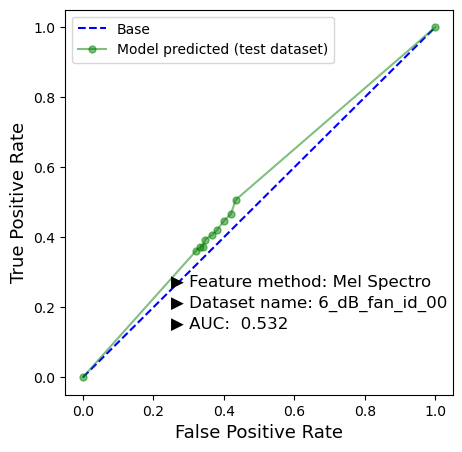

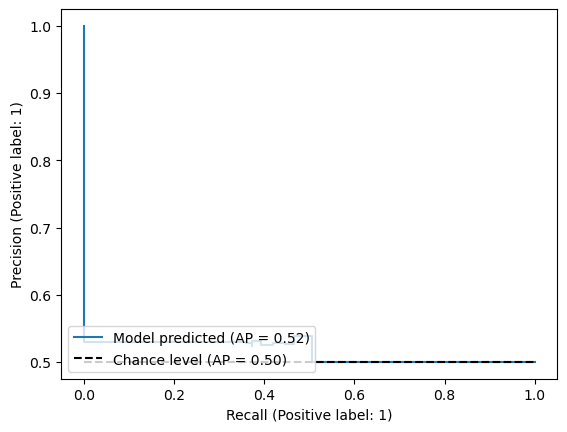

<Figure size 640x480 with 0 Axes>

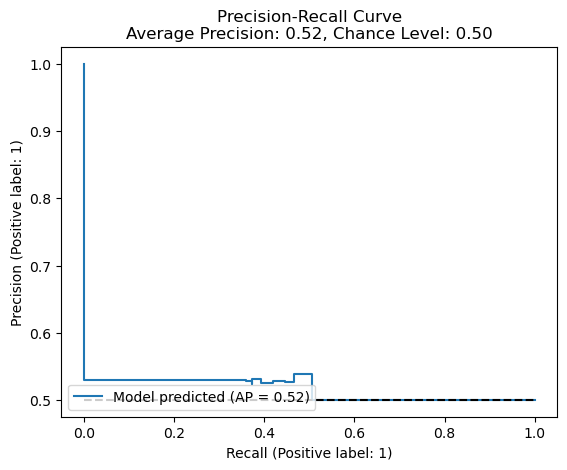

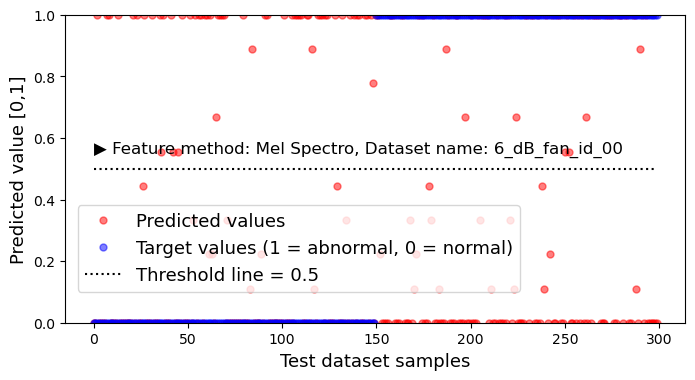

C:\Users\HP\AppData\Local\Temp\ipykernel_12212\2739483378.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results = df_saved_results.append(new_data, ignore_index=True)


In [131]:
base = [0 for _ in range(len(y_true))]
base_auc = roc_auc_score(y_true, base)
pred_auc = roc_auc_score(y_true, y_pred)
print('Model predicted: ROC AUC=%.3f' % (pred_auc))

base_fpr, base_tpr, _ = roc_curve(y_true, base)
pred_fpr, pred_tpr, _ = roc_curve(y_true, y_pred)
file_name1="F:\\Results\\ROC_"+feature_+"_"+dataset_+".png"
plt.figure(figsize=(5,5))
plt.plot(base_fpr, base_tpr, linestyle='--', label='Base', color = 'b')
plt.plot(pred_fpr, pred_tpr, label='Model predicted (test dataset)', marker = "o", markersize = 5, color = 'g', alpha = 0.5)
plt.xlabel('False Positive Rate', fontsize = 13)
plt.ylabel('True Positive Rate', fontsize = 13)
plt.text(0.25, 0.14, f'▶ AUC: {pred_auc: 3.3f}', fontsize = 12)
plt.text(0.25, 0.20, f'▶ Dataset name: {dataset_}', fontsize = 12)
plt.text(0.25, 0.26, f'▶ Feature method: {feature_}', fontsize = 12)
plt.legend()
plt.savefig(file_name1)
plt.show()

# Plot PR curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
display = PrecisionRecallDisplay.from_predictions(
    y_true, y_pred, name="Model predicted", plot_chance_level=True
    )
ap = average_precision_score(y_true, y_pred)
chance_level = sum(y_true) / len(y_true)

plt.figure()
display.plot()
chance_line=chance_level*np.ones(2)
plt.plot(chance_line, "--", color = 'black')
file_name2="F:\\Results\\PR_Curve_"+feature_+"_"+dataset_+".png"
plt.title(f'Precision-Recall Curve\nAverage Precision: {ap:.2f}, Chance Level: {chance_level:.2f}')
plt.savefig(file_name2)
plt.show()

threshold_line = threshold*np.ones(len(y_true))
   
# Plot the results: test dataset
s = y_true.argsort()
y_true_2 = y_true[s]
y_pred_2 = y_pred[s]
y_compare = np.hstack((y_true_2.reshape(len(y_true),1), y_pred_2.reshape(len(y_true),1)))
        
plt.figure(figsize=(8,4))
plt.title("")
plt.plot(y_compare[:,1], "o", alpha = 0.5, color = 'r', markersize = 5, label = 'Predicted values')
plt.plot(y_compare[:,0], "o", alpha = 0.5, color = 'b', markersize = 5, label = 'Target values (1 = abnormal, 0 = normal)')
plt.plot(threshold_line, ":", color = 'black', label = f'Threshold line = {threshold}')
plt.xlabel('Test dataset samples', fontsize = 13)
plt.ylabel('Predicted value [0,1]', fontsize = 13)
plt.ylim(0,1)
plt.legend(loc = (0.02, 0.1), fontsize = 13)
plt.text(0.02, 0.55, f'▶ Feature method: {feature_}, Dataset name: {dataset_}', fontsize = 12)
file_name3="F:\\Results\\Distribution_"+feature_+"_"+dataset_+".png"
plt.savefig(file_name3)
plt.show()

test_accuracy=(test_m1.result().numpy()+test_m4.result().numpy())/(test_m1.result().numpy()+test_m2.result().numpy()+test_m3.result().numpy()+test_m4.result().numpy())
train_accuracy=(train_m4.result().numpy()+train_m1.result().numpy())/(train_m4.result().numpy()+train_m1.result().numpy()+train_m2.result().numpy()+train_m3.result().numpy())

new_data = {"Method":feature_, "Dataset":dataset_, 
            "ROC_curve_AUC_test":pred_auc, "PR_curve_AP_test" : ap, "PR_curve_Chance_level":chance_level,
            "TP_train":train_m1.result().numpy(), "FP_train":train_m2.result().numpy(),
            "FN_train":train_m3.result().numpy(),"TN_train":train_m4.result().numpy(),
            "TP_test":test_m1.result().numpy(), "FP_test":test_m2.result().numpy(),
            "FN_test":test_m3.result().numpy(),"TN_test":test_m4.result().numpy(),
            "Accuracy_test":test_accuracy,"Accuracy_train":train_accuracy
            }
df_saved_results = df_saved_results.append(new_data, ignore_index=True)

In [134]:
df_saved_results.to_csv('output.csv', index=False)

In [ ]:
df_saved_results.tail()